# Predicting Taxi Orders in the Next Hour

The Sweet Lift Taxi company needs more drivers during peak hours.  It has collected historical data on taxi orders at airports and it wishes to predict the amount of taxi orders for the next hour. 

This project is to train and compare different models with different hyperparameters to make these predictions. The stated aim is to acheive an RMSE metric on the test set of not more than 48.

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Data Preparation

We first import and investigate the data:

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('/Users/Steve Lewis/practicum_datasets/taxi.csv')

In [3]:
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


There are 26,496 rows in this dataframe and only 2 columns: (1) a timestamp and (2) the number of taxi orders.  We will read in the data again, this time parsing the dates in the 1st (datetime) column: 

In [5]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/Users/Steve Lewis/practicum_datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The datatime column is now the index.

We need to be sure that the data is in chronological order: 

In [8]:
data.sort_index(inplace=True)

In [9]:
print(data.index.is_monotonic)

True


This confirms that the data is chronological for the 6 month period from March 1 to August 31 2018.

### Resampling the Data by 1 Hour

The length of the time intervals in the dataset is 10 minutes. We will change this to 1 hour:

In [10]:
data = data.resample('1H').sum()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


There are now 4416 rows in the dataset. We will do a last check to ascertain if any of the index values are duplicated:

In [12]:
data.index.duplicated().sum()

0

## Analysis

We need to confirm that the data is *stationary* before we can do forecasting on it, ie that it has constant statistical properties over time.  Specifically, this means that we have to confirm a constant mean and variance.

We will create a function that we can use to plot the statistics we need:

In [13]:
def plot_data(series, roll_period):
   
    rolmean = series.rolling(roll_period).mean()
    rolstd = series.rolling(roll_period).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,8))
    orig = plt.plot(series, color='lightblue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

We will run the funtion on a subset of the data to be sure to be able to view the plot fully:

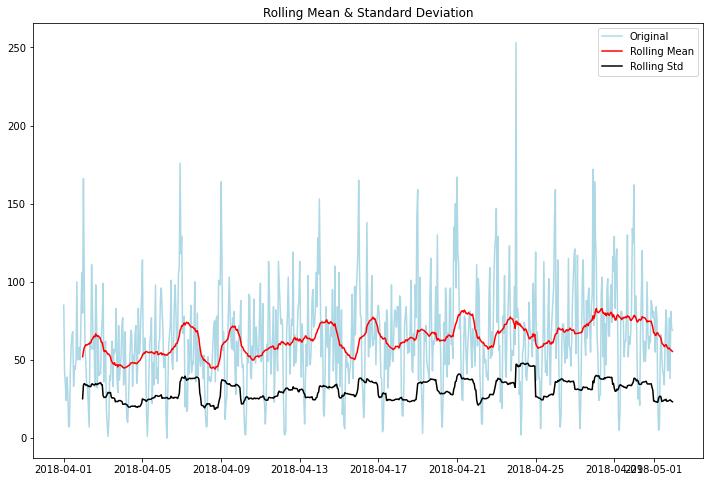

In [14]:
# series = timeseries[start:end]['num_orders']
series = data['2018-04-01':'2018-05-01']['num_orders']
plot_data(series, 24)

The mean and STD are fluctuating; it looks like some seasonality is present. In addition it looks like there is an upward trend for the mean.

We will mow carry out two investigations to determine if these can be smoothed out: differencing and decomposition.

### Differencing

Differencing calculates the difference between the data and the data shifted by a particular time lag.  The default time lag of shift() is 1 period (which in this case is 1 hour). 

We will apply this to the log of the values, in order to reduce the range of the data:

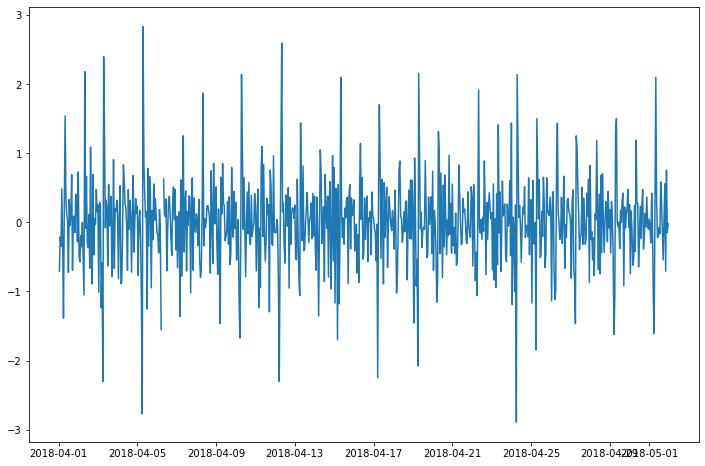

In [15]:
log_series = np.log(data['2018-04-01':'2018-05-01']['num_orders'])
log_diff = log_series - log_series.shift()
plt.figure(figsize=(12,8))
plt.plot(log_diff)

This data now looks much more stationary.  We plot the mean and STD:

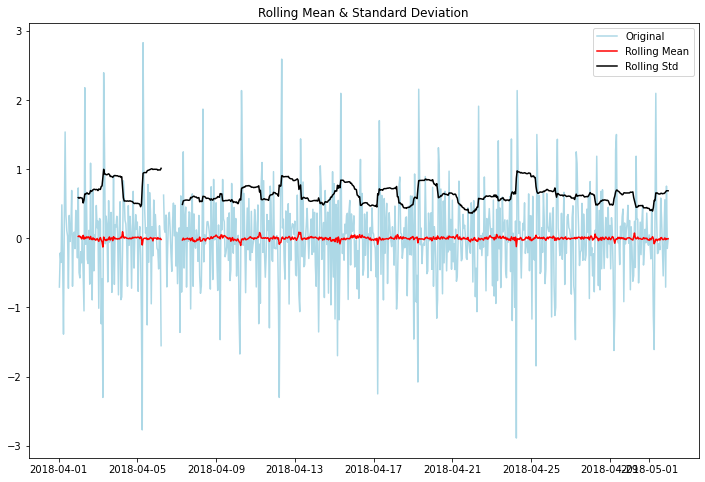

In [16]:
plot_data(log_diff, 24)

The mean in the above plot looks to be pretty much horizontal. The standard deviation fluctuates, though within a much narrower range (0.5 to 1).

### Decomposition

Now we will use the tsa.seasonal module of the statsmodels library to decompose the data into ***trend, seasonal and residual*** components and plot the results:

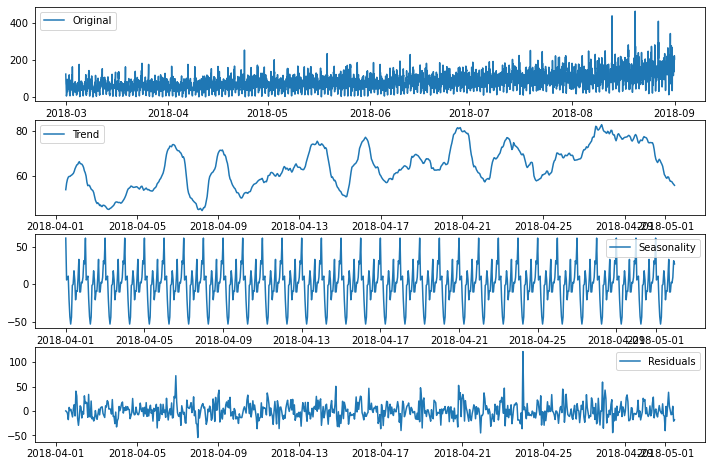

In [17]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-05-01'])
plt.figure(figsize=(12, 8))

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

The 1st graph is the graph of the original (non-decomposed) data. 

The next graph (of the **Trend**) clearly shows a rising trend over the course of the month.

The 3rd graph of **Seasonality** shows a very clear repeating pattern.

The last graph is the 'noise' (the **Residuals**).

Lets look at an even smaller sample of 3 days only to get a better sense of the seasonality:

<AxesSubplot:xlabel='datetime'>

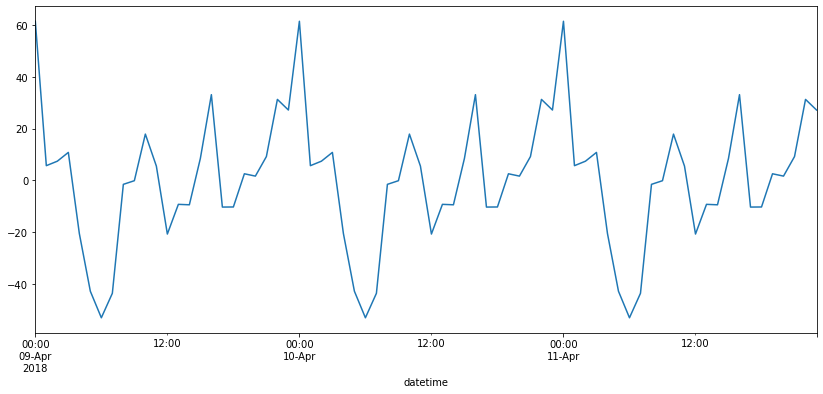

In [18]:
seasonal['2018-04-09' : '2018-04-11'].plot(figsize=(14, 6))

We clearly see a regular daily repeated pattern with a peak at around midnight that falls to a low at around 6am. The number of orders then increases with lower peaks at around 11am and 3pm. The daily swings go from -60 to +60.

Let's plot the mean and the STD on the residual data only:

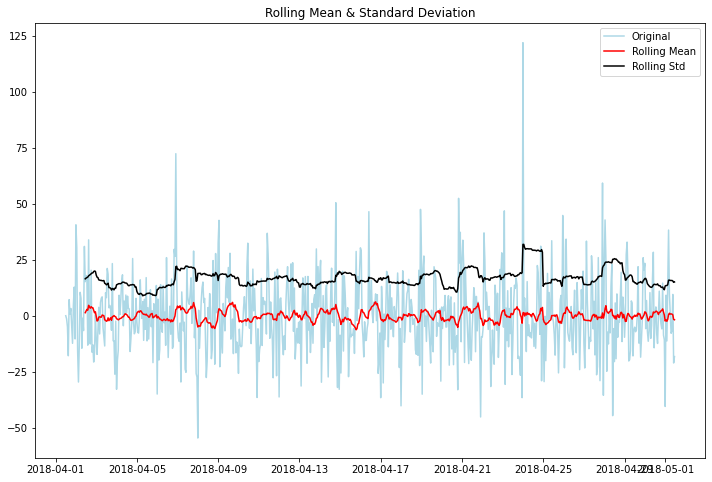

In [19]:
residual.dropna(inplace=True)
plot_data(residual, 24)

The standard deviation has soothed out somewhat.

Conclusion: we confirm that we can create features in order that the data becomes stationary.  We can therefore move to model training.

## Creating New Features

The task now is to create new features from the data with which to train the model:

In [20]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


We will create the following features:

- Datetime features - estracted directly from the date and time of each observation
- Lag features - creating lags in the data to see if there is correlation between the lagged data and the target variable
- Rolling window statistics - summary statistics (mean, max, min) accross a specified window
- Expanding window statistics - summary statistics (mean, max, min) that include *all previous data* in the series.

Rolling and expanding window statistics should be calculated on the data shifted back by one period in order to avoid data leakage.

We define a function to create these features with given time-series data:

In [21]:
def make_features(data, max_lag, rolling_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_size).mean())
    data['rolling_max'] = (data['num_orders'].shift().rolling(rolling_size).max())
    data['rolling_min'] = (data['num_orders'].shift().rolling(rolling_size).min())
    
    data['window_mean'] = data['num_orders'].shift().expanding().mean()
    data['window_max'] = data['num_orders'].shift().expanding().max()
    data['window_min'] = data['num_orders'].shift().expanding().min()
    
    return data

Now we pass the function our data specifying the maximum lag and the size of the rolling window:

In [22]:
make_features(data, 8, 12)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean,rolling_max,rolling_min,window_mean,window_max,window_min
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.000000,124.0,124.0
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.500000,124.0,85.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333,124.0,71.0
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.500000,124.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,163.416667,217.0,46.0,84.319655,462.0,0.0
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,170.916667,217.0,116.0,84.331369,462.0,0.0
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,168.583333,217.0,116.0,84.347156,462.0,0.0


Some null values have appeared due to the introduction of the now lag and rolling features, so we will drop these: 

In [23]:
data = data.dropna()
data.shape

(4404, 19)

Our data set (of 4404 rows and 19 columns) is now ready for training.

## Model Training

We separate the target variable from the features:

In [24]:
X = data.drop(columns = ['num_orders'])
y = data['num_orders']

We split the data into 3 sets: training, validation and testing. 10% of the data is reserved for the Test set and 10% of the remainder is allocated to the validation set. Crucially, we must not shuffle the data as it needs to remain in chronological order.

In [25]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, shuffle=False, test_size=0.1, random_state=12345)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(3566, 18)
(3566,)
(397, 18)
(397,)
(441, 18)
(441,)


We will print the beginning and end dates of the datasets to confirm that they are in consecutive order:

In [26]:
print(X_train.index.min(), X_train.index.max())
print(X_valid.index.min(), X_valid.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-01 12:00:00 2018-07-28 01:00:00
2018-07-28 02:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3566 entries, 2018-03-01 12:00:00 to 2018-07-28 01:00:00
Freq: H
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         3566 non-null   int64  
 1   day           3566 non-null   int64  
 2   hour          3566 non-null   int64  
 3   dayofweek     3566 non-null   int64  
 4   lag_1         3566 non-null   float64
 5   lag_2         3566 non-null   float64
 6   lag_3         3566 non-null   float64
 7   lag_4         3566 non-null   float64
 8   lag_5         3566 non-null   float64
 9   lag_6         3566 non-null   float64
 10  lag_7         3566 non-null   float64
 11  lag_8         3566 non-null   float64
 12  rolling_mean  3566 non-null   float64
 13  rolling_max   3566 non-null   float64
 14  rolling_min   3566 non-null   float64
 15  window_mean   3566 non-null   float64
 16  window_max    3566 non-null   float64
 17  window_min    3566 non-null

Everything is in order and the data is ready for model training.

### Linear Regression

We will first train a Linear Regression model:

In [28]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred_valid_lr = model_lr.predict(X_valid)

We define a function to calculate the Root Mean Squared Error (RMSE) and we will use this metric to compare models:

In [29]:
def RMSE(target, predictions):

    MSE = mean_squared_error(target, predictions)
    RMSE = MSE**0.5
    return RMSE

Calculating the RMSE of the Linear Regression model on the validation data set:

In [30]:
RMSE_valid_lr = RMSE(y_valid, pred_valid_lr)
RMSE_valid_lr

40.05699339260105

This will serve as our sanity check model upon which we aim to improve with the other models we will train. 

Before moving on, we will investigate the coefficents of the Linear Regression model:

In [31]:
print(X_train.columns)
print(model_lr.coef_)
print(model_lr.intercept_)

Index(['month', 'day', 'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'rolling_mean', 'rolling_max',
       'rolling_min', 'window_mean', 'window_max', 'window_min'],
      dtype='object')
[11.8514311   0.61406565  0.29253889  0.03803375  0.37678392  0.06841044
 -0.06330695 -0.07535752 -0.02317917 -0.08118874  0.04141904  0.03376835
 -0.05417072 -0.04815072  0.34565807 -0.91509283 -0.04118176  1.68370618]
48.7478840587741


### Decision Tree Regression

We now train a number of Decision Tree Regression models, varying the max_depth hyperparameter.  We use the validation set to make predictions and we choose the best model based on the lowest RMSE acheived.

In [32]:
for depth in range(1,10):
    model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_dt.fit(X_train, y_train)
    pred_valid_dt = model_dt.predict(X_valid)
    print('max_depth =', depth, '|', 'RMSE =', RMSE(y_valid, pred_valid_dt))

max_depth = 1 | RMSE = 51.09867888986869
max_depth = 2 | RMSE = 49.14326702088229
max_depth = 3 | RMSE = 44.46652216328041
max_depth = 4 | RMSE = 42.870596736405666
max_depth = 5 | RMSE = 40.39721098067973
max_depth = 6 | RMSE = 37.33267005669372
max_depth = 7 | RMSE = 35.44085783735616
max_depth = 8 | RMSE = 35.1905317800769
max_depth = 9 | RMSE = 35.79793747089548


We select the model with max_depth = 8 as it has the lowest RMSE.

In [33]:
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=8)
model_dt.fit(X_train, y_train)
pred_valid_dt = model_dt.predict(X_valid)
RMSE_valid_dt = RMSE(y_valid, pred_valid_dt)
RMSE_valid_dt

35.1905317800769

We have been able to improve on the RMSE of the Linear Regression model.

### Random Forest Regression

We will train Random Forest Regression models and vary the n_estimators hyperparameter:

In [34]:
for estimator in range(20,45):
    model_rf = RandomForestRegressor(random_state=12345, n_estimators=estimator)
    model_rf.fit(X_train, y_train)
    pred_valid_rf = model_rf.predict(X_valid)
    print('n_estimators =', estimator, '|', 'RMSE =', RMSE(y_valid, pred_valid_rf))

n_estimators = 20 | RMSE = 33.19736606042904
n_estimators = 21 | RMSE = 33.21924829963714
n_estimators = 22 | RMSE = 32.8715901959952
n_estimators = 23 | RMSE = 32.79711946820139
n_estimators = 24 | RMSE = 32.756390343142854
n_estimators = 25 | RMSE = 33.055792116410174
n_estimators = 26 | RMSE = 32.795347324957206
n_estimators = 27 | RMSE = 32.672710960972516
n_estimators = 28 | RMSE = 32.46618027091959
n_estimators = 29 | RMSE = 32.50427576373744
n_estimators = 30 | RMSE = 32.49034178004361
n_estimators = 31 | RMSE = 32.466543267164106
n_estimators = 32 | RMSE = 32.34792943980837
n_estimators = 33 | RMSE = 32.2224090109669
n_estimators = 34 | RMSE = 32.14471573913641
n_estimators = 35 | RMSE = 32.07256349517942
n_estimators = 36 | RMSE = 32.17798597175552
n_estimators = 37 | RMSE = 32.16424906172305
n_estimators = 38 | RMSE = 32.03173307810064
n_estimators = 39 | RMSE = 32.33053059336697
n_estimators = 40 | RMSE = 32.475461526903516
n_estimators = 41 | RMSE = 32.449133003457334
n_est

We select the model with n_estimators = 40 as it has the lowest RMSE.

In [35]:
model_rf = RandomForestRegressor(random_state=12345, n_estimators=40)
model_rf.fit(X_train, y_train)
pred_valid_rf = model_rf.predict(X_valid)
RMSE_valid_rf = RMSE(y_valid, pred_valid_rf)
RMSE_valid_rf

32.475461526903516

This is a further improvement on the Decision Tree Regression model.

We will now train two models that use Gradient Boosting: XGBoost and Catboost.

### XGBoost

We will select the optimum XGBoost model by varying the n_estimators parameter:

In [36]:
for estimator in range(1,100):
    XGB_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = estimator)
    XGB_model.fit(X_train,y_train)
    y_pred_XGB = XGB_model.predict(X_valid)
    print('n_estimators =', estimator, '|', 'RMSE =', RMSE(y_valid, y_pred_XGB))

n_estimators = 1 | RMSE = 110.1884883324606
n_estimators = 2 | RMSE = 101.47167123956376
n_estimators = 3 | RMSE = 94.76004140712145
n_estimators = 4 | RMSE = 88.70965718915598
n_estimators = 5 | RMSE = 82.68723430239417
n_estimators = 6 | RMSE = 77.33564527223638
n_estimators = 7 | RMSE = 72.75158104635086
n_estimators = 8 | RMSE = 67.02699077976501
n_estimators = 9 | RMSE = 63.024202704318434
n_estimators = 10 | RMSE = 60.07895062719519
n_estimators = 11 | RMSE = 56.96025524752864
n_estimators = 12 | RMSE = 54.53745937552333
n_estimators = 13 | RMSE = 52.380367252715
n_estimators = 14 | RMSE = 50.034838157285186
n_estimators = 15 | RMSE = 46.41373143168537
n_estimators = 16 | RMSE = 43.40395436288536
n_estimators = 17 | RMSE = 41.43074507567378
n_estimators = 18 | RMSE = 40.746386712280994
n_estimators = 19 | RMSE = 39.798083592559045
n_estimators = 20 | RMSE = 38.69883085646055
n_estimators = 21 | RMSE = 38.04111665350718
n_estimators = 22 | RMSE = 37.57580022788906
n_estimators = 2

We select the model with n_estimators = 79 as it has the lowest RMSE above

In [37]:
XGB_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 79)
XGB_model.fit(X_train,y_train)
pred_valid_XGB = XGB_model.predict(X_valid)
RMSE_valid_XGB = RMSE(y_valid, pred_valid_XGB)
RMSE_valid_XGB

33.72021045808639

We investigate the importance of the parameters in the XGB Model:

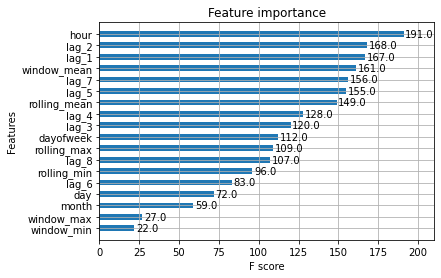

In [38]:
xgb.plot_importance(XGB_model, height=0.5)
plt.rcParams['figure.figsize'] = [15, 15]
plt.yticks(fontsize=10)
plt.show()

The most important feature in the model is the hour.  Next is the previous hour and the previous 2 hours.

### CatBoost 

We run a Catboost model with 1000 iterations:

In [39]:
cb_model = cb.CatBoostRegressor(loss_function= 'RMSE', iterations=1000)
cb_model.fit(X_train, y_train, verbose=100)
valid_pred_cb = cb_model.predict(X_valid)
RMSE_valid_cb = RMSE(y_valid, valid_pred_cb)
print('RMSE_cb =', RMSE_valid_cb)

Learning rate set to 0.050052
0:	learn: 35.3891546	total: 176ms	remaining: 2m 55s
100:	learn: 20.6727144	total: 1.22s	remaining: 10.8s
200:	learn: 18.6517135	total: 2.23s	remaining: 8.88s
300:	learn: 17.2106973	total: 3.76s	remaining: 8.74s
400:	learn: 16.0288785	total: 4.8s	remaining: 7.17s
500:	learn: 15.0523971	total: 5.83s	remaining: 5.8s
600:	learn: 14.1705054	total: 6.74s	remaining: 4.48s
700:	learn: 13.3413849	total: 7.75s	remaining: 3.3s
800:	learn: 12.6420304	total: 8.78s	remaining: 2.18s
900:	learn: 12.0166906	total: 9.69s	remaining: 1.06s
999:	learn: 11.3968561	total: 11s	remaining: 0us
RMSE_cb = 30.28061090377555


We investigate the importance of the parameters in the XGB Model:

In [40]:
from catboost import Pool
train_pool = cb_model.get_feature_importance(Pool(X_train, y_train))
train_pool

array([ 2.18727704,  1.51276109, 41.06635452,  4.17249596,  9.99847606,
        4.49251082,  3.51373243,  2.69314197,  3.26830527,  3.17130793,
        5.31613093,  3.09087364,  3.37366941,  1.7920449 ,  3.15548616,
        5.38732808,  1.20669317,  0.60141061])

In [41]:
catboost_df = pd.DataFrame({'feature_names': X_train.columns, 'feature_importance': train_pool}).sort_values(by=['feature_importance'])
catboost_df

,feature_names,feature_importance
17,window_min,0.601411
16,window_max,1.206693
1,day,1.512761
13,rolling_max,1.792045
0,month,2.187277
7,lag_4,2.693142
11,lag_8,3.090874
14,rolling_min,3.155486
9,lag_6,3.171308
8,lag_5,3.268305


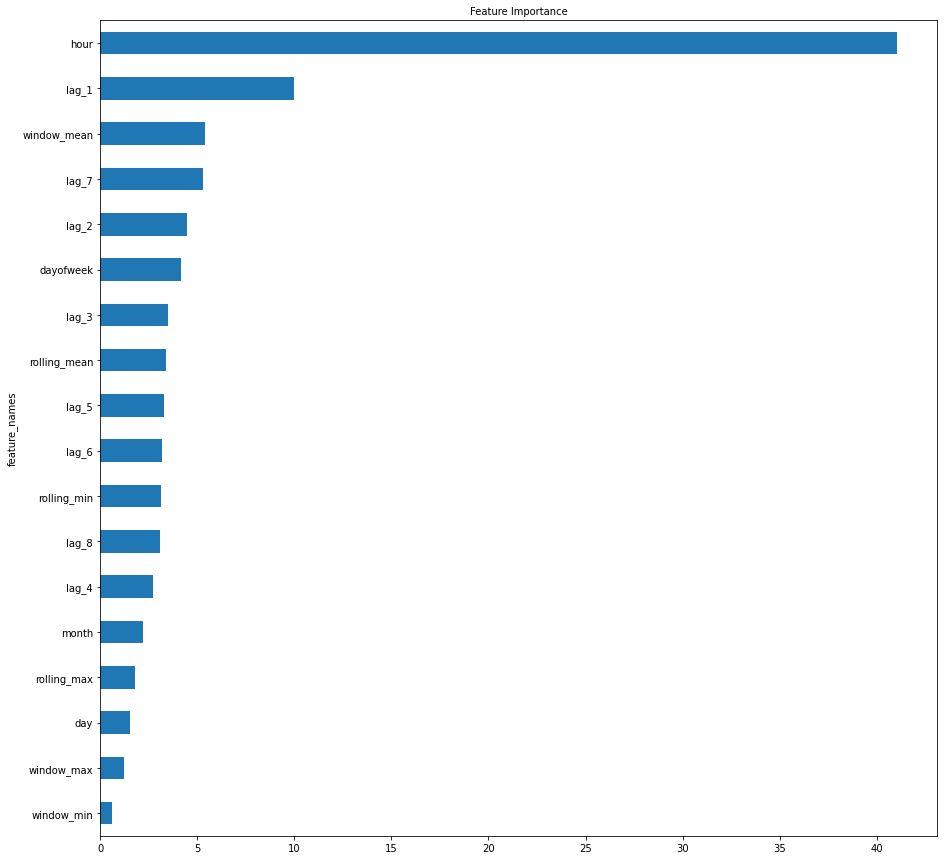

In [42]:
catboost_df.plot(kind = 'barh', x='feature_names', y='feature_importance', legend=None, fontsize=10)
plt.title('Feature Importance', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('')
plt.show()

In the Catboost model, the hour is by far the most important feature in the model.

## Testing

We now compare how each of the models performs on the test set data:

### Linear Regression

In [43]:
pred_test_lr = model_lr.predict(X_test)
RMSE_test_lr = RMSE(y_test, pred_test_lr)
RMSE_test_lr

59.297313314627274

### Decision Tree Regression

In [44]:
pred_test_dt = model_dt.predict(X_test)
RMSE_test_dt = RMSE(y_test, pred_test_dt)
RMSE_test_dt

56.189873146321915

### Random Forest Regression

In [45]:
pred_test_rf = model_rf.predict(X_test)
RMSE_test_rf = RMSE(y_test, pred_test_rf)
RMSE_test_rf

45.78535105903022

### XGBoost Regression

In [46]:
pred_test_xgb = XGB_model.predict(X_test)
RMSE_test_xgb = RMSE(y_test, pred_test_xgb)
RMSE_test_xgb

48.65116179966605

### Catboost Regression

In [47]:
cb_model.fit(X_train, y_train, verbose=100)
test_pred_cb = cb_model.predict(X_test)
RMSE_test_cb = RMSE(y_test, test_pred_cb)
RMSE_test_cb

Learning rate set to 0.050052
0:	learn: 35.3891546	total: 19.8ms	remaining: 19.8s
100:	learn: 20.6727144	total: 3.89s	remaining: 34.7s
200:	learn: 18.6517135	total: 5.57s	remaining: 22.1s
300:	learn: 17.2106973	total: 6.76s	remaining: 15.7s
400:	learn: 16.0288785	total: 7.88s	remaining: 11.8s
500:	learn: 15.0523971	total: 9.21s	remaining: 9.17s
600:	learn: 14.1705054	total: 10.3s	remaining: 6.81s
700:	learn: 13.3413849	total: 11.4s	remaining: 4.85s
800:	learn: 12.6420304	total: 12.5s	remaining: 3.1s
900:	learn: 12.0166906	total: 14.8s	remaining: 1.62s
999:	learn: 11.3968561	total: 16.9s	remaining: 0us


50.290074657571644

In [ ]:
We create a table to compare the RMSEs calculated with each model:

In [48]:
columns = ['Model', 'RMSE (Validation Set)', 'RMSE (Test Set)']

In [49]:
lr = ['Linear Regression', RMSE_valid_lr, RMSE_test_lr]
rf = ['Random Forest Regression', RMSE_valid_rf, RMSE_test_rf]
dt = ['Decision Tree Regression', RMSE_valid_dt, RMSE_test_dt]
xgb = ['XGBoost Regression', RMSE_valid_XGB, RMSE_test_xgb]
cb = ['Catboost Regression', RMSE_valid_cb, RMSE_test_cb]

In [50]:
RMSE = pd.DataFrame([lr, rf, dt, xgb, cb], columns=list(columns))
RMSE

,Model,RMSE (Validation Set),RMSE (Test Set)
0,Linear Regression,40.056993,59.297313
1,Random Forest Regression,32.475462,45.785351
2,Decision Tree Regression,35.190532,56.189873
3,XGBoost Regression,33.720210,48.651162
4,Catboost Regression,30.280611,50.290075


### Conclusions

The Random Forest Regression model performed best on the test set data with an RMSE acheived of 45.78 (which is under the specified threshold of 48). 

Although the Catboost Regressor performed best on the validation set, the RMSE on the test set was not under the specified threshold.  However, it is possible the XGBoost and Catboost models could be improved with additional hyper-parameter training.